### Monte Carlo
First vs. Every Visit MC
* Tracking rewards received after visiting states
* Rewards received after first visit → First visit MC
* Rewards received after every visit → Every visit MC

### Blackjack Overview
* Player vs. Dealer; first to 21 wins, > 21 is a loss (bust)
* Ace worth 1 or 11, other face cards worth 10
* Ace that doesn’t cause a bust is called usable
* One dealer card is showing
* Inifinte deck with replacement → no counting
* State space is a 3 tuple:
    * Player sum (4-21), 
    * dealer showing card (ace – 10), 
    * boolean for a usable ace
* Reward +1 for winning, 0 for draw, -1 for loss
* Policy: draw new card (hit) if player total < 20, else stick

### Algorithm Overview
* Initialize the policy to be evaluated
* Initialize the value function arbitrarily
* Initialize list of returns for all states in the state space
* Repeat for large number of episodes:
    * Generate episode using policy
    * For each state s in the agent’s memory:
        * Calculate the return that followed first visit to s
        * Append return G to list of returns
        * Calculate the average of the returns for state s
* 500,000 games → print value of state (21, 2, True)
* Split into agent class and main function

In [1]:
import shutup
shutup.please()

import gym
import enum
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rich.table import Table
from rich.console import Console

### BlackJack setup
* Game and card setup
* Dealer turn logic
* Dealer hand value evaluation logic
* Player hand value evaluation logic

In [2]:
RANKS = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"
    
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in RANKS.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

In [3]:
import random
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

INITIAL_BALANCE = 1000
NUM_DECKS = 2

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, num_decks = NUM_DECKS, initial_balance=INITIAL_BALANCE):
        super(BlackjackEnv, self).__init__()
        
        # Initialize the blackjack deck.
        self.deck = Deck(num_decks)
        self.initial_balance = initial_balance
        
        self.player_hand = []
        self.dealer_hand = []
        
        self.reward_options = {"lose":-100, "tie":0, "win":100}
        
        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)
        
        '''
        First element of tuple is the range of possible hand values for the player. (3 through 20)
        This is the possible range of values that the player will actually have to make a decision for.
        Any player hand value 21 or above already has automatic valuations, and needs no input from an
        AI Agent. 
        
        However, we also need to add all the hand values that the agent could possibly end up in when
        they bust. Maybe the agent can glean some correlations based on what hand value they bust at,
        so this should be in the observation space. Also, the layout of OpenAI Gym environment class
        makes us have to include the bust-value in the step() function because we need to return that
        done is true alongside the final obs, which is the bust-value.
        '''
        
        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))
        
        self.done = False
        
    
    ### HAND EVALUATION LOGIC  
    def dealer_hand_value_evaluation(self,hand):
        num_ace = 0
        use_one = 0
        for card in hand:
            if card.rank =="ace":
                num_ace +=1
                use_one += card.value[0] # Assume 1 for Ace
            else:
                use_one += card.value
                
        if num_ace > 0:
            # If has 11 instead of 1 for aces, dealer's hand is closer to the [17,21] range
            # Will follow Hard 17 rules ( dealer wont hi again is Ace yields a 17 )
            # Aces can be changed to 1's
            ace_counter = 0
            while ace_counter < num_ace:
                use_eleven = use_one + 10
                if use_eleven > 21:
                    return use_one
                elif use_eleven >= 17 and use_eleven <= 21:
                    return use_eleven
                else:
                    # The case where even using Ace as eleven is less than 17.
                    use_one = use_eleven
            
                ace_counter += 1
            return use_one
        else:
            return use_one
            
    def player_hand_value_evaluation(self,hand):
        num_ace = 0
        # use_one means that every ace that in the hand is counted as one.
        use_one = 0
        for card in hand:
            if card.rank == "ace":
                num_ace += 1
                use_one += card.value[0] # use 1 for Ace
            else:
                use_one += card.value

        if num_ace > 0:
            # Define player policy for Aces:
            # Make Aces 11 if they get you to the range [18,21]
            # Otherwise, use one.
            ace_counter = 0
            while ace_counter < num_ace:
                use_eleven = use_one + 10 

                if use_eleven > 21:
                    return use_one
                elif use_eleven >= 18 and use_eleven <= 21:
                    return use_eleven
                else:
                    # This allows for some Aces to be 11s, and others to be 1.
                    use_one = use_eleven

                ace_counter += 1

            return use_one
        else:
            return use_one
        
    ### PLAYER BET POLICY
    def discrete_policy(self,hand, deck):
        value = self.player_hand_value_evaluation(hand)

        # Implement Discrete Policy
        # If hand >= 18, stand. Otherwise, hit.
        while value < 18:
            # hit
            hand.append(deck.deal())
            value = self.player_hand_value_evaluation(hand)

        return value, hand, deck

    def stochastic_policy(self,hand, deck):
        value = self.player_hand_value_evaluation(hand)

        # Implement Stochastic Policy
        # If hand >= 18: 80% Stand, 20% Hit
        # Else: 80% Hit, 20% Stand

        stand = False
        while value < 18 and stand == False:
            percent = random.randint(1, 10)
            if percent <= 8:
                # hit
                hand.append(deck.deal())
                value = self.player_hand_value_evaluation(hand)
            else:
                # stand
                stand = True
    
        if stand:
            return value, hand, deck
    
        # player_value is now >= 18.
        if value < 21:
            percent = random.randint(1, 10)
            if percent > 8:
                # hit
                hand.append(deck.deal())
                value = self.player_hand_value_evaluation(hand)        

            # else: Do nothing, stand.
            # else: player_value is 21 or higher, so we must stand in both cases.

        return value, hand, deck
    
    
    ### TURN EVALUATION LOGIC
    def dealer_turn(self,dealer_hand,deck):
        # Calculate dealer hand's value.
        dealer_value = self.dealer_hand_value_evaluation(dealer_hand)
        
        # Define dealer policy (is fixed to official rules)

        # The dealer keeps hitting until their total is 17 or more
        while dealer_value < 17:
            # hit
            dealer_hand.append(deck.deal())
            dealer_value = self.dealer_hand_value_evaluation(dealer_hand)

        return dealer_value, dealer_hand, deck
        
    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.deck.deal())
            
        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = self.player_hand_value_evaluation(self.player_hand)
    
    def step(self, action):
        self._take_action(action)
        
        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21
        
        # rewards are 0 when the player hits and is still below 21, and they
        # keep playing.
        rewards = 0
        
        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: # above 21, player loses automatically.
                rewards = self.reward_options["lose"]
            elif self.player_value == 21: # blackjack! Player wins automatically.
                rewards = self.reward_options["win"]
            else:
                ## Begin dealer turn phase.

                dealer_value, self.dealer_hand, self.deck = self.dealer_turn(self.dealer_hand, self.deck)

                ## End of dealer turn phase

                #------------------------------------------------------------#

                ## Final Compare

                if dealer_value > 21: # dealer above 21, player wins automatically
                    rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        rewards = self.reward_options["lose"]
                    else:
                        rewards = self.reward_options["tie"]
        
        self.balance += rewards
        
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
        
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = self.dealer_hand_value_evaluation([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs, rewards, self.done, {}
    
    def reset(self): # resets game to an initial state
        # Add the player and dealer cards back into the deck.
        self.deck.cards += self.player_hand + self.dealer_hand

        # Shuffle before beginning. Only shuffle once before the start of each game.
        self.deck.shuffle()
         
        self.balance = self.initial_balance
        
        self.done = False
        
        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.deck.deal(), self.deck.deal()]
        self.dealer_hand = [self.deck.deal(), self.deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]
        
        # calculate the value of the agent's hand
        self.player_value = self.player_hand_value_evaluation(self.player_hand)
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
            
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = self.dealer_hand_value_evaluation([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs
    
    def render(self, mode='human', close=False):
        # convert the player hand into a format that is
        # easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.rank)
            
        # re-calculate the value of the dealer upcard.
        upcard_value = self.dealer_hand_value_evaluation([self.dealer_upcard])
        
        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')
        
        print()

In [45]:
class BlackJackAgent:
    def __init__(self, environment, alpha = 0.001,epsilon=1,decay = 0.9999,epsilon_min = 0.9,gamma = 0.8):
        self.env = environment 
        # The learning rate. Very small to avoid making quick, large changes in our policy.
        self.alpha = alpha

        self.epsilon = epsilon

        # The rate by which epsilon will decay over time.
        # Since the probability we take the option with the highest Q-value is 1-epsilon + probability,
        # this decay will make sure we are the taking the better option more often in the longrun.
        # This allows the algorithm to explore in the early stages, and exploit in the later stages.
        self.decay = decay

        # The lowest value that epsilon can go to.
        # Although the decay seems slow, it actually grows exponentially, and this is magnified when
        # running thousands of episodes.
        self.epsilon_min = epsilon_min

        # may have to be tweaked later.
        self.gamma = gamma
        
        # Create tables
        self.__init_buffers()
        
    def __init_buffers(self):
        self.Q = np.zeros([self.env.observation_space[0].n * self.env.observation_space[1].n, self.env.action_space.n], dtype=np.float16)

        # This map contains the probability distributions for each action (hit or stand) given a state.
        # The state (combo of player hand value and dealer upcard value) index in this array yields a 2-element array
        # The 0th index of this 2-element array refers to the probability of "hit", and the 1st index is the probability of "stand"
        self.prob = np.zeros([self.env.observation_space[0].n * self.env.observation_space[1].n, self.env.action_space.n], dtype=np.float16) + 0.5
    
    
    ### GAME LOGIC
    def run_mc(self,num_episodes):
        '''
        observation_space[0] is the 18 possible player values. (3 through 20)
        observation_space[1] is the 10 possible dealer upcards. (2 through 11)

        Combining these together yields all possible states.

        Multiplying this with hit/stand yields all possible state/action pairs.

        This is the Q map.
        '''
        self.Q = np.zeros([self.env.observation_space[0].n * self.env.observation_space[1].n, self.env.action_space.n], dtype=np.float16)


        # This map contains the probability distributions for each action (hit or stand) given a state.
        # The state (combo of player hand value and dealer upcard value) index in this array yields a 2-element array
        # The 0th index of this 2-element array refers to the probability of "hit", and the 1st index is the probability of "stand"
        self.prob = np.zeros([self.env.observation_space[0].n * self.env.observation_space[1].n, self.env.action_space.n], dtype=np.float16) + 0.5

        for _ in range(num_episodes):
            episode = self.play_game()

            self.epsilon = max(self.epsilon * self.decay, self.epsilon_min)

            Q = self.update_Q(episode)
            prob = self.update_prob(episode)

        return Q, prob
    
    ### Q LEARNING
    def get_Q_state_index(self,state):
        # the player value is already subtracted by 1 in the env when it returns the state.
        # subtract by 1 again to fit with the array indexing that starts at 0
        initial_player_value = state[0] - 1
        # the upcard value is already subtracted by 1 in the env when it returns the state.
        # dealer_upcard will be subtracted by 1 to fit with the array indexing that starts at 0
        dealer_upcard = state[1] - 1

        return (self.env.observation_space[1].n * (initial_player_value)) + (dealer_upcard)
        
    def update_Q(self,episode):
        '''
        THIS IS WHERE THE ALGORITHM HINGES ON BEING FIRST VISIT OR EVERY VISIT.
        I AM GOING TO USE FIRST-VISIT, AND HERE'S WHY.

        If you want first-visit, you need to use the cumulative reward of the entire
        episode when updating a Q-value for ALL of the state/action pairs in the
        episode, even the first state/action pair. In this algorithm, an episode
        is a round of Blackjack. Although the bulk of the reward may come from the
        2nd or 3rd decision, deciding to hit on the 1st decision is what enabled
        the future situations to even occur, so it is important to include the
        entire cumulative reward. We can reduce the impact of the rewards of the
        future decisions by lowering gamma, which will lower the G value for our
        early state/action pair in which we hit and did not get any immediate rewards.
        This will make our agent consider future rewards, and not just look at 
        each state in isolation despite having hit previously.

        If you want Every-Visit MC, do not use the cumulative rewards when updating Q-values,
        and just use the immediate reward in this episode for each state/action pair.
        '''
        step = 0
        for state, action, reward in episode:
            # calculate the cumulative reward of taking this action in this state.
            # Start from the immediate rewards, and use all the rewards from the
            # subsequent states. Do not use rewards from previous states.
            total_reward = 0
            gamma_exp = 0
            for curr_step in range(step, len(episode)):
                curr_reward = episode[curr_step][2]
                total_reward += (self.gamma ** gamma_exp) * curr_reward
                gamma_exp += 1

            # Update the Q-value
            Q_state_index = self.get_Q_state_index(state)
            curr_Q_value = self.Q[Q_state_index][action]
            self.Q[Q_state_index][action] = curr_Q_value + self.alpha * (total_reward - curr_Q_value)

            # update step to start further down the episode next time.
            step += 1


        return self.Q

    def get_prob_of_best_action(self,state):
        # Use the mapping function to figure out which index of Q corresponds to 
        # the player hand value + dealer upcard value that defines each state.
        Q_state_index = self.get_Q_state_index(state)

        # Use this index in the Q 2-D array to get a 2-element array that yield
        # the current Q-values for hitting (index 0) and standing (index 1) in this state.
        # Use the np.argmax() function to find the index of the action that yields the
        # rewards i.e. the best action we are looking for.
        best_action = np.argmax(self.Q[Q_state_index])

        # Retrieve the probability of the best action using the 
        # state/action pair as indices for the `prob` array,
        # which stores the probability of taking an action (hit or stand)
        # for a given state/action pair.
        return self.prob[Q_state_index][best_action]

    def update_prob_of_best_action(self,state):

        Q_state_index = self.get_Q_state_index(state)

        best_action = np.argmax(self.Q[Q_state_index])

        # Slightly alter the probability of this best action being taken by using epsilon
        # Epsilon starts at 1.0, and slowly decays over time.
        # Therefore, as per the equation below, the AI agent will use the probability listed 
        # for the best action in the `prob` array during the beginning of the algorithm.
        # As time goes on, the likelihood that the best action is taken is increased from
        # what is listed in the `prob` array.
        # This allows for exploration of other moves in the beginning of the algorithm,
        # but exploitation later for a greater reward.
        #prob[Q_state_index][best_action] = prob[Q_state_index][best_action] + ((1 - epsilon) * (1 - prob[Q_state_index][best_action]))
        self.prob[Q_state_index][best_action] = min(1, self.prob[Q_state_index][best_action] + 1 - self.epsilon)

        other_action = 1 if best_action == 0 else 0
        self.prob[Q_state_index][other_action] = 1 - self.prob[Q_state_index][best_action]

        return self.prob
    
    def update_prob(self,episode):
        for state, action, reward in episode:
            # Update the probabilities of the actions that can be taken given the current
            # state. The goal is that the new update in Q has changed what the best action
            # is, and epsilon will be used to create a small increase in the probability
            # that the new, better action is chosen.
            prob = self.update_prob_of_best_action(state)

        return self.prob

    def play_game(self):
        # Can contain numerous state->action->reward tuples because a round of 
        # Blackjack is not always resolved in one turn.
        # However, there will be no state that has a player hand value that exceeds 20, since only initial
        # states BEFORE actions are made are used when storing state->action->reward tuples.
        episode = []

        state = self.env.reset()

        while self.env.done == False:
            if state[0] == 19: #Player was dealt Blackjack, player_value already subtracted by 2 to get state[0]
                # don't do any episode analysis for this episode. This is a useless episode.
                next_state, reward, self.env.done, info = self.env.step(1) # doesn't matter what action is taken.
            else:
                # Get the index in Q that corresponds to the current state
                Q_state_index = self.get_Q_state_index(state)

                # Use the index to get the possible actions, and use np.argmax()
                # to get the index of the action that has the highest current Q
                # value. Index 0 is hit, index 1 is stand.
                best_action = np.argmax(self.Q[Q_state_index])

                # Go to the prob table to retrieve the probability of this action.
                # This uses the same Q_state_index used for finding the state index
                # of the Q-array.
                prob_of_best_action = self.get_prob_of_best_action(state)

                action_to_take = None

                if random.uniform(0,1) < prob_of_best_action: # Take the best action
                    action_to_take = best_action
                else: # Take the other action
                    action_to_take = 1 if best_action == 0 else 0

                # The agent does the action, and we get the next state, the rewards,
                # and whether the game is now done.
                next_state, reward, self.env.done, info = self.env.step(action_to_take)

                # We now have a state->action->reward sequence we can log
                # in `episode`
                episode.append((state, action_to_take, reward))

                # update the state for the next decision made by the agent.
                state = next_state

        return episode
    
    def best_policy(self,Q):
        best_policy_binary = []
        best_policy_string = []
        best_policy_colors = []
        for i in range(len(Q)):
            best_policy_binary.append(np.argmax(Q[i]))
            best_policy_string.append("Hit" if np.argmax(Q[i]) == 0 else "Stand")
            best_policy_colors.append("g" if np.argmax(Q[i]) == 0 else "r")

        return best_policy_binary, best_policy_string, best_policy_colors
    
    def learn(self,episodes=1000000, plot=True):
        new_Q, new_prob = self.run_mc(episodes)
        self.new_Q = new_Q
        self.new_prob = new_prob
        self.new_Q_binary, self.new_Q_string, self.new_Q_colors =self.best_policy(self.new_Q)
                    
        if plot:
            df = pd.DataFrame(columns = range(2, 12))

            color_df = pd.DataFrame(columns = range(2, 12))

            for s in range(3, 21): # possible player values in the range 3 to 20
                start = self.env.observation_space[1].n * (s-3)
                end = start + 10
                df.loc[s]=(self.new_Q_string[start:end])
                color_df.loc[s]=(self.new_Q_colors[start:end])

            fig, ax = plt.subplots()

            # hide axes
            fig.patch.set_visible(False)
            ax.set_axis_off()
            ax.axis('tight')

            ax.table(cellText=df.values, cellColours=color_df.values, cellLoc="center", rowLabels=df.index, colLabels=df.columns, loc='center')
            ax.set_title('X = Dealer hand value, Y = player hand value', pad=20)
            fig.tight_layout()

            plt.show()
                    
    def test(self,episodes = 100000):
        total_rewards = 0

        for _ in range(episodes):
            state = self.env.reset()

            while self.env.done == False:
                if state[0] == 19: # Player was dealt Blackjack
                    next_state, reward, self.env.done, info = self.env.step(1) # doesn't matter what action is taken.
                    # don't do any episode analysis for this episode. This is a useless episode.
                    total_rewards += reward
                else:
                    Q_index = self.get_Q_state_index(state)
                    action = self.new_Q_binary[Q_index]

                    new_state, reward, done, desc = self.env.step(action)
                    state = new_state
                    total_rewards += reward

        avg_reward = total_rewards / episodes
        print(avg_reward)

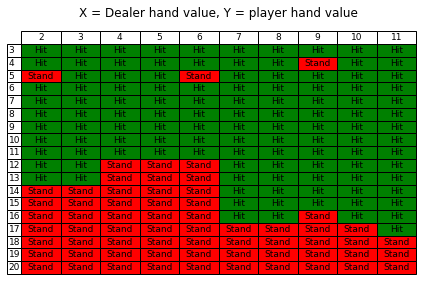

In [47]:
environment = BlackjackEnv()
agent= BlackJackAgent(environment)
agent.learn(episodes = 5000000)

In [48]:
agent.test()

-4.361
